# Simulation with the Shyft api

## Introduction
At its core, Shyft provides functionality through an API (Application Programming Interface). All the functionality of Shyft is available through this API.

We begin the tutorials by introducing the API as it provides the building blocks for the framework. Once you have a good understan

In [Part I](run_nea_nidelva.ipynb) of the simulation tutorials, we covered conducting a very simple simulation of an example catchment using configuration files. This is a typical use case, but assumes that you have a model well configured and ready for simulation. In practice, one is interested in working with the model, testing different configurations, and evaluating different data sources.

This is in fact a key idea of Shyft -- to make it simple to evaluate the impact of the selection of model routine on the performance of the simulation. In this notebook we walk through a lower level paradigm of working with the toolbox and using the Shyft API directly to conduct the simulations.

**This notebook is guiding through the simulation process of a catchment. The following steps are described:**
1. **Loading required python modules and setting path to SHyFT installation**
2. **Running of a Shyft simulation**
3. **Running a Shyft simulation with updated parameters**
4. **Activating the simulation only for selected catchments**
5. **Setting up different input datasets**
6. **Changing state collection settings**
7. **Post processing and extracting results**

## 1. Loading required python modules and setting path to SHyFT installation

Shyft requires a number of different modules to be loaded as part of the package. Below, we describe the required steps for loading the modules, and note that some steps are only required for the use of the jupyter notebook.

In [1]:
# Pure python modules and jupyter notebook functionality
# first you should import the third-party python modules which you'll use later on
# the first line enables that figures are shown inline, directly in the notebook
%matplotlib inline
import os
import datetime as dt
import pandas as pd
from os import path
import sys
from matplotlib import pyplot as plt
from netCDF4 import Dataset

### The Shyft Environment

This next step is highly specific on how and where you have installed Shyft. If you have followed the guidelines at github, and cloned the three shyft repositories: i) shyft, ii) shyft-data, and iii) shyft-doc, then you may need to tell jupyter notebooks where to find shyft. Uncomment the relevant lines below.

If you have a 'system' shyft, or used `conda install -s sigbjorn shyft` to install shyft, then you probably will want to make sure you have set the SHYFTDATA directory correctly, as otherwise, Shyft will assume the above structure and fail. __This has to be done _before_ `import shyft`__. In that case, uncomment the relevant lines below.

**note**: it is most likely that you'll need to do one or the other.

In [2]:
# now we create the shyft specific environment
# set the path for your shyft build
# this should point to the directory that is created
# when you clone shyft, assuming you have built shyft
# there and not installed it to your system python
# if you followed the recommendations in the README, then
# you will have cloned three git repos in a parallel structure
# and can point to the shyft repository:
# Note: you could achieve the same by setting a PYTHONPATH

# sys.path.insert(0,os.environ['SHYFT_DEPENDENCIES_DIR'])
# shyft_path = os.path.abspath("../../../shyft")
# sys.path.insert(0, shyft_path)

# If you have set up a system shyft installation, or it has
# been set up for you somewhere, then you need to tell these
# notebooks where to find the data. This is relevant with respect
# to how the .yaml configuration files are set up. Set this to
# point to directory where you cloned the git repos on your machine.
# shyft-data should be in that directory
if 'SHYFTDATA' not in os.environ:
    os.environ['SHYFTDATA'] = os.path.join(os.environ['HOME'],'workspace/shyft_workspace')
    
print(os.environ['SHYFTDATA'])

D:\statkraft_data


In [3]:
from shyft import api
import shyft

print(shyft.__path__)

['C:\\Miniconda3\\envs\\shyft\\lib\\site-packages\\shyft-4.4.1472-py3.6.egg\\shyft']


## 2. A Shyft simulation

The purpose of this notebook is to demonstrate setting up a Shyft simulation using existing **repositories**. Eventually, you will want to learn to write your own repositories, but once you understand what is presented herein, you'll be well on your way to working with Shyft.

If you prefer to take a **high level** approach, you can start by looking at the [Run Nea Nidelva](simulation-yaml.ipynb) notebook. We recommend taking the time to understand the lower level functionality of Shyft, however, as it will be of value later if you want to use your own data and create your own repositories.

### Orchestration and Repositories
A core philosophy of Shyft is that "Data should live at the source". What this means, is that we prefer datasets to either remain in their original format or even come directly from the data provider. To accomplish this, we use "repositories". You can read more about repositories at the [Shyft Documentation](https://shyft.readthedocs.io/en/latest/orchestration.html).

#### Interfaces
Because it is our hope that users will create their own repositories to meet the specifications of their own datasets, we provide 'interfaces'. This is a programming concept that you may not be familiar with. The idea is that it is a basic example, or template, of how the class should work. You can use these and your own class can inherit from them, allowing you to override methods to meet your own specifications. We'll explore this as we move through this tutorial. A nice [explanation of interfaces with python is available here](http://masnun.rocks/2017/04/15/interfaces-in-python-protocols-and-abcs/).

### Initial Configuration
What is required to set up a simulation? In the following we'll package some basic information into a dictionaries that may be used to configure our simualtion. We'll start by creating a couple of dictionaries that will be used to instantiate an existing **repository** class that was created for demonstration purposes, `CFRegionModelRepository`.

If it hasn't been said enough, there is *a lot of functionality in the repositories!* You can write a repository to suit your own use case, and it is encouraged to look at this source code. 

In [4]:
# we need to import the repository to use it in a dictionary:
from shyft.repository.netcdf.cf_region_model_repository import CFRegionModelRepository

#### region specification

The first dictionary essentially establishes the domain of the simulation. We also specify a repository that is used to read the data that will provide Shyft a `region_model` (discussed below), based on geographic data. The geographic consists of properties of the catchment, e.g. "forest fraction", "lake fraction", etc.

In [5]:
# next, create the simulation dictionary
RegionDict = {'region_model_id': 'demo', #a unique name identifier of the simulation
              'domain': {'EPSG': 32633,
                        'nx': 400,
                        'ny': 80,
                        'step_x': 1000,
                        'step_y': 1000,
                        'lower_left_x': 100000,
                        'lower_left_y': 6960000},
              'repository': {'class': shyft.repository.netcdf.cf_region_model_repository.CFRegionModelRepository,
                             'params': {'data_file': 'shyft-data/netcdf/orchestration-testdata/cell_data.nc'}},
          }

The first keys, are probably quite clear:

* `start_datetime`: a string in the format: "2013-09-01T00:00:00"
* `run_time_step`: an integer representing the time step of the simulation (in seconds), so for a daily step: 86400
* `number_of_steps`: an integer for how long the simulatoin should run: 365 (for a year long simulation)
* `region_model_id`: a string to name the simulation: 'neanidelva-ptgsk'

We also need to know *where* the simulation is taking place. This information is contained in the `domain`:

* `EPSG`: an EPSG string to identify the coordinate system
* `nx`: number of 'cells' in the x direction
* `ny`: number of 'cells' in the y direction
* `step_x`: size of cell in x direction (m)
* `step_y`: size of cell in y direction (m)
* `lower_left_x`: where (x) in the EPSG system the cells begin
* `lower_left_y`: where (y) in the EPSG system the cells begin
* `repository`: a repository that can read the file containing data for the cells (in this case it will read a netcdf file)

#### Model specification

The next dictionary provides information about the model that we would like to use in Shyft, or the 'Model Stack' as it is generally referred to. In this case, we are going to use the PTGSK model, and the rest of the dictionary provides the parameter values.

In [6]:
ModelDict = {'model_t': shyft.api.pt_gs_k.PTGSKModel,  # model to construct
            'model_parameters': {
                'actual_evapotranspiration':{
                    'ae_scale_factor': 1.5},
                'gamma_snow':{
                    'calculate_iso_pot_energy': False,
                    'fast_albedo_decay_rate': 6.752787747748934,
                    'glacier_albedo': 0.4,
                    'initial_bare_ground_fraction': 0.04,
                    'max_albedo': 0.9,
                    'max_water': 0.1,
                    'min_albedo': 0.6,
                    'slow_albedo_decay_rate': 37.17325702015658,
                    'snow_cv': 0.4,
                    'tx': -0.5752881492890207,
                    'snowfall_reset_depth': 5.0,
                    'surface_magnitude': 30.0,
                    'wind_const': 1.0,
                    'wind_scale': 1.8959672005350063,
                    'winter_end_day_of_year': 100},
                'kirchner':{ 
                    'c1': -3.336197322290274,
                    'c2': 0.33433661533385695,
                    'c3': -0.12503959620315988},
                'precipitation_correction': {
                    'scale_factor': 1.0},
                'priestley_taylor':{'albedo': 0.2,
                    'alpha': 1.26},
                    }
            }               

In this dictionary we define two variables:

* `model_t`: the import path to a shyft 'model stack' class
* `model_parameters`: a dictionary containing specific parameter values for a particular model class

Specifics of the `model_parameters` dictionary will vary based on which class is used.

Okay, so far we have two dictionaries. One which provides information regarding our simulation domain, and a second which provides information on the model that we wish to run over the domain (e.g. in each of the cells). The next step, then, is to map these together and create a `region_repo` class.

This is achieved by using a repository, in this case, the `CFRegionModelRepository` we imported above.

In [7]:
region_repo = CFRegionModelRepository(RegionDict, ModelDict)

### The `region_model`

<div class="alert alert-info">

**TODO:** a notebook documenting the CFRegionModelRepository

</div>

The first step in conducting a hydrologic simulation is to define the **domain of the simulation** and the **model type** which we would like to simulate. To do this we create a `region_model` object. Above we created dictionaries that contain this information, and we instantiated a class called teh `region_repo`. In this next step, we put it together so that we have a single object which we can work with "at our fingertips". You'll note above that we have pointed to a 'data_file' earlier when we defined the `RegionDict`. This data file contains all the required elements to fill the cells of our domain. The informaiton is contained in a single [netcdf file](../../../shyft-data/netcdf/orchestration-testdata/cell_data.nc)

Before we go further, let's look briefly at the contents of this file:

In [8]:
cell_data_file = os.path.join(os.environ['SHYFTDATA'], 'shyft-data/netcdf/orchestration-testdata/cell_data.nc')
cell_data = Dataset(cell_data_file)
print(cell_data)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): cell(4650)
    variables(dimensions): float64 x(cell), float64 y(cell), float64 z(cell), int32 crs(), float64 area(cell), float64 forest-fraction(cell), float64 reservoir-fraction(cell), float64 lake-fraction(cell), float64 glacier-fraction(cell), int32 catchment_id(cell)
    groups: 



You might be surprised to see the dimensions are 'cells', but recall that in Shyft everything is vectorized. Each 'cell' is an element within a domain, and each cell has associated variables:

* location: x, y, z
* characteristics: forest-fraction, reservoir-fraction, lake-fraction, glacier-fraction, catchment-id

We'll bring this data into our workspace via the `region_model`. Note that we have instantiated a `region_repo` class using one of the existing Shyft repositories, in this case one that was built for reading in the data as it is contained in the example [shyft-data](https://github.com/statkraft/shyft-data) netcdf files: `CFRegionModelRepository`.


Next, we'll use the `region_repo.get_region_model` method to get the `region_model`. Note the name 'demo', in this case is arbitrary. However, depending on how you create your repository, you can specify what region model to return using this string.
<div class="alert alert-info">


**note:** *you are strongly encouraged to learn how to create repositories. This particular repository is just for demonstration purposes. In practice, one may use a repository that connects directly to a GIS service, a database, or some other data sets that contain the data required for simulations.*

<div class="alert alert-warning">

**warning**: *also, please note that below we call the 'get_region_model' method as we instantiate the class. This behavior may change in the future.*

</div>
</div>

In [9]:
region_model = region_repo.get_region_model('demo')

#### Exploring the `region_model`

So we now have created a `region_model`, but what is it actually? This is a very **fundamental class** in Shyft. It is actually one of the "model stacks", such as 'PTGSK', or 'PTHSK'. Essentially, the `region_model` contains all the information regarding the simulation type and domain. There are many methods associated with the `region_model` and it will take time to understand all of them. For now, let's just explore a few key methods:

* `bounding_region`: provides information regarding the domain of interest for the simulation
* `catchment_id_map`: indices of the various catchments within the domain
* `cells`: an instance of `PTGSKCellAllVector` that holds the individual cells for the simulation (*note that this is type-specific to the model type*)
* `ncore`: an integer that sets the numbers of cores to use during simulation (Shyft is very greedy if you let it!)
* `time_axis`: a `shyft.api.TimeAxisFixedDeltaT` class (basically contains information regarding the timing of the simulation)

Keep in mind that many of these methods are more 'C++'-like than 'Pythonic'. This means, that in some cases, you'll have to 'call' the method. For example: `region_model.bounding_region.epsg()` returns a string. You can use tab-completion to explore the `region_model` further:

In [10]:
region_model.bounding_region.epsg()

'32633'

You'll likely note that there are a number of intriguing fucntions, e.g. `initialize_cell_environment` or `interpolate`. But before we can go further, we need some more information. Perhaps you are wondering about forcing data. So far, we haven't said anything about **model input** or the **time** of the simulation, we've only set up a container that holds all the domain and model type information about our simulation. 

Still, we have made *some* progress. Let's look for instance at the cells:

In [11]:
cell_0 = region_model.cells[0]
print(cell_0.geo)

GeoCellData(mid_point=GeoPoint(204843.7371537306,6994695.209048475,978.344970703125),catchment_id=2305,area=209211.92418108872,ltf=LandTypeFractions(glacier=0.0,lake=0.0,reservoir=0.0,forest=0.0,unspecified=1.0))


So you can see that so far, each of the cells in the region_model contain information regarding their LandTypeFractions, geolocation, catchment_id, and area. 

A particulary important attribute is `region_model.region_env`. This is a container for each cell that holds the "environmental timeseries", or forcing data, for the simulation. By "tabbing" from `cell.` you can see that each cell also has and `env_ts` attribute. These are containers customized to provide timeseries as required by the model type we selected, but there is no data yet. In this case we used the `PTGSKModel` (see the `ModelDict`). So for every cell in your simulation, there is a container prepared to accept the forcing data as the next cell shows.

In [12]:
#just so we don't see 'private' attributes
print([d for d  in dir(cell_0.env_ts) if  '_'  not in d[0]]) 
region_model.size()

['init', 'precipitation', 'radiation', 'rel_hum', 'temperature', 'wind_speed']


4650

### Adding forcing data to the `region_model`

Clearly the next step is to add forcing data to our `region_model` object. Let's start by thinking about what kind of data we need. From above, where we looked at the `env_ts` attribute, it's clear that this particular model stack, `PTGSKModel`, requires:

* precipitation
* radiation
* relative humidity (rel_hum)
* temperature
* wind speed

We have stored this information each in seperate netcdf files which each contain the observational series for a number of different stations. 

<div class="alert alert-warning">

Again, these files **do not represent the recommended practice**, but are *only for demonstration purposes*. The idea here is just to demonstrate with an example repository, but *you should create your own to match **your** data*.

</div>

Our goal now is to populate the `region_env`. 

#### "Sources"

We use the term *sources* to define a location data may be coming from. You may also come across *destinations*. In both cases, it just means a file, database, service of some kind, etc. that is capable of providing data. Repositories are written to connect to *sources*. Following our earlier approach, we'll create another dictionary to define our data sources, but first we need to import another repository:

In [13]:
from shyft.repository.netcdf.cf_geo_ts_repository import CFDataRepository

In [14]:
from shyft.repository.netcdf.cf_geo_ts_repository import CFDataRepository
ForcingData = {'sources': [
        
    {'repository': shyft.repository.netcdf.cf_geo_ts_repository.CFDataRepository,
     'params': {'epsg': 32633,
            'selection_criteria': None,
            'stations_met': 'shyft-data/netcdf/orchestration-testdata/precipitation.nc'},
     'types': ['precipitation']},
       
    {'repository': shyft.repository.netcdf.cf_geo_ts_repository.CFDataRepository,
     'params': {'epsg': 32633,
            'selection_criteria': None,
            'stations_met': 'shyft-data/netcdf/orchestration-testdata/temperature.nc'},
    'types': ['temperature']},
        
    {'params': {'epsg': 32633,
            'selection_criteria': None,
            'stations_met': 'shyft-data/netcdf/orchestration-testdata/wind_speed.nc'},
     'repository': shyft.repository.netcdf.cf_geo_ts_repository.CFDataRepository,
     'types': ['wind_speed']},
    
    {'repository': shyft.repository.netcdf.cf_geo_ts_repository.CFDataRepository,
     'params': {'epsg': 32633,
            'selection_criteria': None,
            'stations_met': 'shyft-data/netcdf/orchestration-testdata/relative_humidity.nc'},
     'types': ['relative_humidity']},
    
    {'repository': shyft.repository.netcdf.cf_geo_ts_repository.CFDataRepository,
     'params': {'epsg': 32633,
            'selection_criteria': None,
            'stations_met': 'shyft-data/netcdf/orchestration-testdata/radiation.nc'},
     'types': ['radiation']}]
      }


#### Data Repositories

In another notebook, further information will be provided regarding the repositories. For the time being, let's look at this configuration dictionary that was created. It essentially just contains a list, keyed by the name `"sources"`. This key is known in some of the tools that are built in the Shyft orchestration, so it is recommended to use it.

Each item in the list is a dictionary for each of the source types, the keys in the dictionaries are: `repository`, `params`, and `types`. The general idea and concept is that in orchestration, the object keyed by `repository` is a class that is instantiated by passing the objects contained in `params`.

Let's repeat that. From our `Datasets` dictionary, we get a list of `"sources"`. Each of these sources contains a class (a repository) that is capable of getting the source data into Shyft. Whatever parameters that are required for the class to work, will be included in the `"sources"` dictionary. In our case, the `params` are quite simple, just a path to a netcdf file. But suppose our repository required credentials or other information for a database? This information could also be included in the `params` stanza of the dictionary.

You should explore the above referenced netcdf files that are available at the [shyft-data](https://github.com/statkraft/shyft-data) git repository. These files contain the forcing data that will be used in the example simulation. Each one contains observational data from some stations in our catchment. Depending on how you write your repository, this data may be provided to Shyft in many different formats.

Let's explore this concept further by getting the 'temperature' data:

In [15]:
# get the temperature sources:
tmp_sources = [source for source in ForcingData['sources'] if 'temperature' in source['types']]

# in this example there is only one
t0 = tmp_sources[0]

# We will now instantiate the repository with the parameters that are provided
# in the dictionary. 
# Note the 'call' structure expects params to contain keyword arguments, and these
# can be anything you want depending on how you create your repository
tmp_repo = t0['repository'](**t0['params'])


`tmp_repo` is now an instance of the Shyft `CFDataRepository`, and this will provide Shyft with the data when it sets up a simulation by reading the data directly out of the file referenced in the 'source'. But that is just one repository, and we defined many in fact. Furthermore, you may have a heterogenous collection of data sources -- if for example you want to get your temperature from station data, but radiation from model output. You could define different repositories in the `ForcingData` dictionary.

Ultimately, we bundle all these repositories up into a new class called a `GeoTsRepositoryCollection` that we can use to populate the `region_model.region_env` with data.

In [16]:
# we'll actually create a collection of repositories, as we have different input types.
from shyft.repository.geo_ts_repository_collection import GeoTsRepositoryCollection

def construct_geots_repo(datasets_config, epsg=None):
    """ iterates over the different sources that are provided 
    and prepares the repository to read the data for each type"""
    geo_ts_repos = []
    src_types_to_extract = []
    for source in datasets_config['sources']:
        if epsg is not None:
            source['params'].update({'epsg': epsg})
        # note that here we are instantiating the different source repositories
        # to place in the geo_ts list 
        geo_ts_repos.append(source['repository'](**source['params']))
        src_types_to_extract.append(source['types'])
    
    return GeoTsRepositoryCollection(geo_ts_repos, src_types_per_repo=src_types_to_extract)

# instantiate the repository
geots_repo = construct_geots_repo(ForcingData)

`geots_repo` is now a "geographic timeseries repository", meaning that the timeseries it holds are spatially aware of their x,y,z coordinates (see `CFDataRepository` for details). It also has several methods. One in particular we are interested in is the `get_timeseries` method. **However, before we can proceed, we need to define the period for the simulation.**

#### Shyft `TimeAxis`
Time in Shyft is handled with specialized C++ types for computational efficiency. These are custom built objects that are 'calendar' aware. But since in python, most like to use `datetime` objects, we create a function:

In [17]:
# next, create the simulation dictionary
TimeDict = {'start_datetime': "2013-09-01T00:00:00",
           'run_time_step': 86400, # seconds, daily
           'number_of_steps': 365 # one year
           }

def time_axis_from_dict(t_dict):
    utc = api.Calendar()
    
    sim_start = dt.datetime.strptime(t_dict['start_datetime'], "%Y-%m-%dT%H:%M:%S")
    utc_start = utc.time(api.YMDhms(sim_start.year, sim_start.month,\
                               sim_start.day, sim_start.hour, \
                               sim_start.minute, sim_start.second))
    tstep = t_dict['run_time_step']
    nstep = t_dict['number_of_steps']
    time_axis = api.TimeAxisFixedDeltaT(utc_start, tstep, nstep)
    
    return time_axis

time_axis = time_axis_from_dict(TimeDict)
print(time_axis.total_period())

[2013-09-01T00:00:00Z,2014-09-01T00:00:00Z>


We now have an object that defines the time dimension for the simulation, and we will use this to initialize the `region_model` with the "environmental timeseries" or `env_ts` data. These containers will be given data from the appropriate repositories using the `get_timeseries` function. Following the templates in the `shyft.repository.interfaces` module, you'll see that the repositories should provide the capability to "screen" data based on time criteria and *optinally** geo_location criteria. 

In [18]:
# we can extract our "bounding box" based on the `region_model` we set up
bbox = region_model.bounding_region.bounding_box(region_model.bounding_region.epsg())

period = time_axis.total_period() #just defined above

# required forcing data sets we want to retrieve
geo_ts_names = ("temperature", "wind_speed", "precipitation",
                              "relative_humidity", "radiation")

sources = geots_repo.get_timeseries( geo_ts_names, period, geo_location_criteria=bbox )

C:\Miniconda3\envs\shyft\lib\site-packages\shyft-4.4.1472-py3.6.egg\shyft\repository\netcdf\cf_geo_ts_repository.py:280: RuntimeWarning: invalid value encountered in greater
  pure_arr = data[data_slice]


Now we have a new dictionary, called 'sources' that contains specialized Shyft api types specific to each forcing data type. You can look at one for example:

In [19]:
prec = sources['precipitation']
print(len(prec))


10


We can explore further and see each element is in itself an `api.PrecipitationSource`, which has a timeseries (ts). Recall from the [first tutorial](run_nea_nidelva.ipynb#Visualizing-the-discharge-for-each-[sub-]catchment) that we can easily convert the `timeseries.time_axis` into datetime values for plotting.

Let's plot the precip of each of the sources:

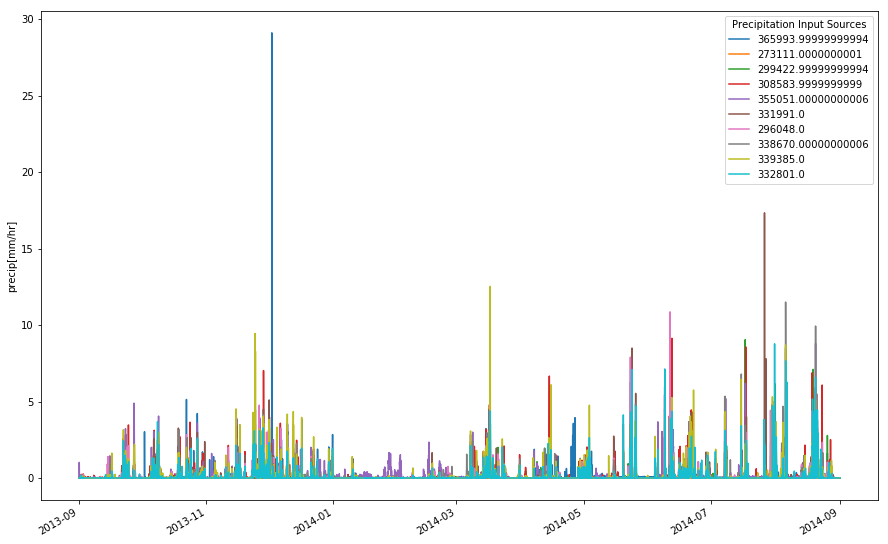

In [20]:
fig, ax = plt.subplots(figsize=(15,10))

for pr in prec:
    t,p = [dt.datetime.utcfromtimestamp(t_.start) for t_ in pr.ts.time_axis], pr.ts.values
    ax.plot(t,p, label=pr.mid_point().x) #uid is empty now, but we reserve for later use
fig.autofmt_xdate()
ax.legend(title="Precipitation Input Sources")
ax.set_ylabel("precip[mm/hr]")

Finally, the next step will take the data from the sources and connect it to our `region_model.region_env` class:

In [21]:
def get_region_environment(sources):
    region_env = api.ARegionEnvironment()
    region_env.temperature = sources["temperature"]
    region_env.precipitation = sources["precipitation"]
    region_env.radiation = sources["radiation"]
    region_env.wind_speed = sources["wind_speed"]
    region_env.rel_hum = sources["relative_humidity"]
    return region_env

region_model.region_env = get_region_environment(sources)

And now our forcing data is connected to the `region_model`. We are *almost* ready to run a simulation. There is just one more step. We've connected the sources to the model, but remember that Shyft is a distributed modeling framework, and we've connected point data sources (in this case). So we need to get the data from the observed *points* to each cell. This is done through interpolation.

### Shyft Interpolation
In Shyft there are predefined routines for interpolation. In the `interp_config` class below one quickly recognizes the same input source type keywords that are used as keys to the `params` dictionary. `params` is simply a dictionary of dictionaries which contains the parameters used by the interpolation model that is specific for each source type.

In [22]:
from shyft.repository.interpolation_parameter_repository import InterpolationParameterRepository

class interp_config(object):
    """ a simple class to provide the interpolation parameters """

    def __init__(self):
        
        self.interp_params = {'precipitation': {'method': 'idw',
          'params': {'distance_measure_factor': 1.0,
           'max_distance': 600000.0,
           'max_members': 10,
           'scale_factor': 1.02}},
         'radiation': {'method': 'idw',
          'params': {'distance_measure_factor': 1.0,
           'max_distance': 600000.0,
           'max_members': 10}},
         'relative_humidity': {'method': 'idw',
          'params': {'distance_measure_factor': 1.0,
           'max_distance': 600000.0,
           'max_members': 10}},
         'temperature': {'method': 'btk',
          'params': {'nug': 0.5,
           'range': 200000.0,
           'sill': 25.0,
           'temperature_gradient': -0.6,
           'temperature_gradient_sd': 0.25,
           'zscale': 20.0}},
         'wind_speed': {'method': 'idw',
          'params': {'distance_measure_factor': 1.0,
           'max_distance': 600000.0,
           'max_members': 10}}}

    def interpolation_parameters(self):
        return self.interp_params

ip_conf = interp_config()
ip_repo = InterpolationParameterRepository(ip_conf)

region_model.interpolation_parameter = ip_repo.get_parameters(0) #just a '0' for now

The next step is to set the intial states of the model using our last repository. This one, the `GeneratedStateRepository` will set empty default values.

Now we are nearly ready to conduct a simulation. We just need to run a few methods to prepare the model and cells for the simulation. The region_model has a method called `initalize_cell_environment` that takes a `time_axis` type as input. We defined the `time_axis` above, so now we'll use it to initialize the model. At the same time, we'll set the initial_state. Then we can actually run a simulation!

In [23]:
from shyft.repository.generated_state_repository import GeneratedStateRepository

init_values = {'gs': {'acc_melt': 0.0,
   'albedo': 0.65,
   'alpha': 6.25,
   'iso_pot_energy': 0.0,
   'lwc': 0.1,
   'sdc_melt_mean': 0.0,
   'surface_heat': 30000.0,
   'temp_swe': 0.0},
  'kirchner': {'q': 0.01}}

   
state_repo = GeneratedStateRepository(region_model, init_values=init_values)

# we need the state_repository to have the same size as the model
state_repo.n = region_model.size()
# there is only 1 state (indexed '0')
region_model.initial_state = state_repo.get_state(0)

### Conduct the simulation
We now have a `region_model` that is ready for simulation. As we discussed before, we still need to get the data from our point observations interpolated to the cells, and we need to get the `env_ts` of each cell populated. But all the machinery is now in place to make this happen. 

To summarize, we've created:

* `region_repo`, a region repository that contains information related to region of simulation and the model to be used in the simulation. From this we get a `region_model`
* `geots_repo`, a geo-timeseries repository that provides a mechanism to pull the data we require from our 'sources'.
* `time_axis`, created from the TimeAxisFixedDeltaT class of `shyft` to provide the period of simulation.
* `ip_repo`, an interpolation repository which provides all the required parameters for interpolating our data to the distributed cells -- following variable specific protocols/models.
* `state_repo`, a `GeneratedStateRepository` used to provide our simulation an initial state.

The next step is simply to initialize the cell environment and run the interpolation. As a practive, before simulation we reset to the initial state (we're there already, but it is something you have to do before a new simulation), and then run the cells. First we'll initialize the cell environment:


In [24]:
region_model.initialize_cell_environment(time_axis)


As a habit, we have a quick "sanity check" function to see if the model is runnable. Itis recommended to have this function when you create 'run scripts'.

In [25]:
def runnable(reg_mod):
    """ returns True if model is properly configured 
    **note** this is specific depending on your model's input data requirements """
    return all((reg_mod.initial_state.size() > 0, reg_mod.time_axis.size() > 0,
                   all([len(getattr(reg_mod.region_env, attr)) > 0 for attr in
                    ("temperature", "wind_speed", "precipitation", "rel_hum", "radiation")])))

In [26]:
# run the model, e.g. as you may configure it in a script:
if runnable(region_model):
    
    region_model.interpolate(region_model.interpolation_parameter, region_model.region_env)
    region_model.revert_to_initial_state()
    region_model.run_cells()
else:
    print('Something wrong with model configuration.')


    

Okay, so the simulation was run. Now we may be interested in looking at some of the output. We'll take a brief summary glance in the next section, and save a deeper dive into the simulation results for another notebook.


## 3. Simulation results

The first step will be simply to look at the discharge results for each subcatchment within our simulation domain. For simplicity, we can use a `pandas.DataFrame` to collect the data from each catchment.

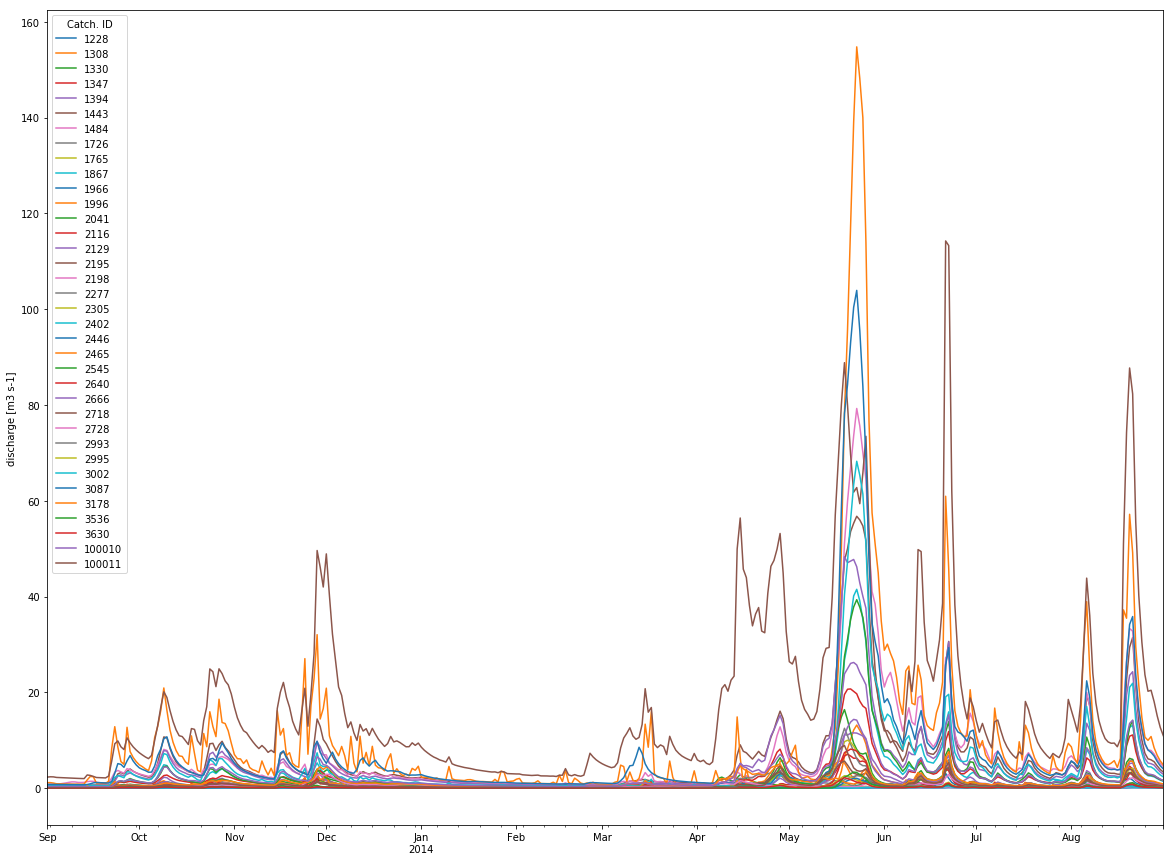

In [27]:
# Here we are going to extact data from the simulation.
# We start by creating a list to hold discharge for each of the subcatchments.
# Then we'll get the data from the region_model object

# mapping of internal catch ID to catchment
catchment_id_map = region_model.catchment_id_map 

# First get the time-axis which we'll use as the index for the data frame
ta = region_model.time_axis
# and convert it to datetimes
index = [dt.datetime.utcfromtimestamp(p.start) for p in ta]

# Now we'll add all the discharge series for each catchment 
data = {}
for cid in catchment_id_map:
    # get the discharge time series for the subcatchment
    q_ts = region_model.statistics.discharge([int(cid)])
    data[cid] = q_ts.values.to_numpy()

df = pd.DataFrame(data, index=index)
# we can simply use:
ax = df.plot(figsize=(20,15))
ax.legend(title="Catch. ID")
ax.set_ylabel("discharge [m3 s-1]")

Okay, that was simple. Let's look at the timeseries in some individual cells. The following is a bit of a contrived example, but it shows some aspects of the api. We'll plot the temperature series of all the cells in one sub-catchment, and color them by elevation. This doesn't necessarily show anything about the simulation, per se, but rather results from the interpolation step.

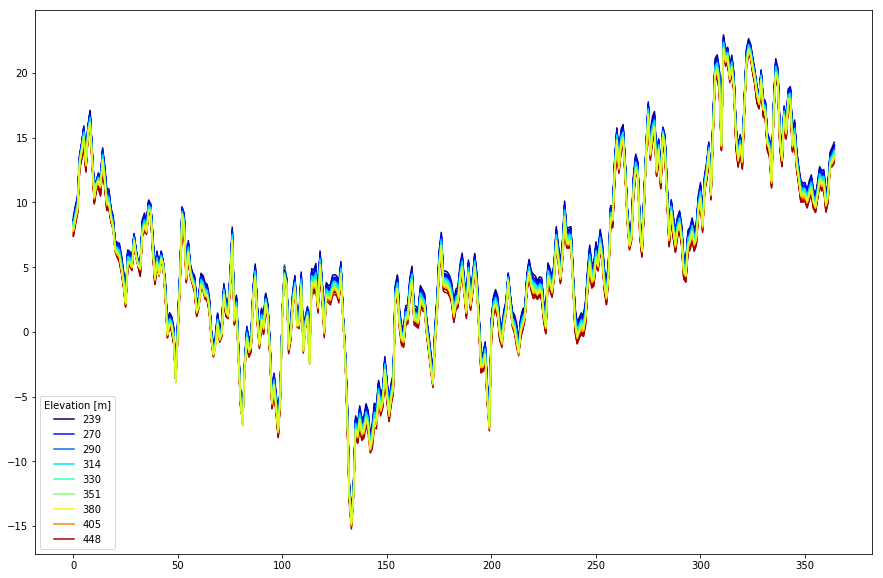

In [28]:
from matplotlib.cm import jet as jet
from matplotlib.colors import Normalize

# get all the cells for one sub-catchment with 'id' == 1228
c1228 = [c for c in region_model.cells if c.geo.catchment_id() == 1228]

# for plotting, create an mpl normalizer based on min,max elevation
elv = [c.geo.mid_point().z for c in c1228]
norm = Normalize(min(elv), max(elv))

#plot with line color a function of elevation
fig, ax = plt.subplots(figsize=(15,10))

# here we are cycling through each of the cells in c1228
for dat,elv in zip([c.env_ts.temperature.values for c in c1228], [c.mid_point().z for c in c1228]):
    ax.plot(dat, color=jet(norm(elv)), label=int(elv))
    
    
# the following is just to plot the legend entries and not related to Shyft
handles, labels = ax.get_legend_handles_labels()

# sort by labels
import operator
hl = sorted(zip(handles, labels),
            key=operator.itemgetter(1))
handles2, labels2 = zip(*hl)

# show legend, but only every fifth entry
ax.legend(handles2[::5], labels2[::5], title='Elevation [m]')

As we would expect from the temperature kriging method, we should find higher elevations have colder temperatures. As an exercise you could explore this relationship using a scatter plot.

Now we're going to create a function that will read initial states from the `initial_state_repo`. In practice, this is already done by the `ConfgiSimulator`, but to demonstrate lower level functions, we'll reset the states of our `region_model`:

In [29]:
# create a function to read the states from the state repository
def get_init_state_from_repo(initial_state_repo_, region_model_id_=None, timestamp=None):
    state_id = 0
    if hasattr(initial_state_repo_, 'n'):  # No stored state, generated on-the-fly
        initial_state_repo_.n = region_model.size()
    else:
        states = initial_state_repo_.find_state(
            region_model_id_criteria=region_model_id_,
            utc_timestamp_criteria=timestamp)
        if len(states) > 0:
            state_id = states[0].state_id  # most_recent_state i.e. <= start time
        else:
            raise Exception('No initial state matching criteria.')
    return initial_state_repo_.get_state(state_id)
 
init_state = get_init_state_from_repo(state_repo, timestamp=region_model.time_axis.start)


Don't worry too much about the function for now, but do take note of the `init_state` object that we created. This is another container, this time it is a class that contains `PTGSKState` objects, which are specific to the model stack implemented in the simulation (in this case `PTGSK`). If we explore an individual state object, we'll see `init_state` contains, for each cell in our simulation, the state variables for each 'method' of the method stack.

Let's look more closely:

In [30]:
def print_pub_attr(obj):
    #only public attributes
    print([attr for attr in dir(obj) if attr[0] is not '_']) 
    
print(len(init_state))
init_state_cell0 = init_state[0]
# gam snow states and kirchner states
print_pub_attr(init_state_cell0.gs)
print_pub_attr(init_state_cell0.kirchner)

# kirchner discharge, cell0
print(init_state_cell0.kirchner.q)


4650
['acc_melt', 'albedo', 'alpha', 'iso_pot_energy', 'lwc', 'sdc_melt_mean', 'surface_heat', 'temp_swe']
['q']
0.01


#### Summary
We have now explored the `region_model` and looked at how to instantiate a `region_model` by using a `api.ARegionEnvironment`, containing a collection of timeseries sources, and passing an `api.InterpolationParameter` class containing the parameters to use for the data interpolation algorithms. The interpolation step "populated" our cells with data from the point sources.

The cells each contain all the information related to the simulation (their own timeseries, `env_ts`; their own model parameters, `parameter`; and other attributes and methods). In future tutorials we'll work with the cells indivdual "resource collector" (`.rc`) and "state collector" (`.sc`) attributes.



